# Machine learning tutorial at CMSDAS at CERN, June 2024
## Exercise 4: regression using a dense neural network

Evan Armstrong Koenig, Matthias Komm, Pietro Vischia

The core of this tutorial comes from https://github.com/vischia/data_science_school_igfae2024 (Pietro Vischia (pietro.vischia@cern.ch)).

The CMSDAS version extends it to consider a convolutional network to regress Higgs quantities, plus some fixes.


In [1]:
# Uncomment and run this if you are running on Colab (remove only the "#", keep the "!").
# You can run it anyway, but it will do nothing if you have already installed all dependencies
# (and it will take some time to tell you it is not gonna do anything)


#from google.colab import drive
#drive.mount('/content/drive')
#%cd "/content/drive/MyDrive/"
#! git clone https://github.com/vischia/data_science_school_igfae2024.git
#%cd machine_learning_tutorial
#!pwd
#!ls
#!pip install livelossplot shap

In [2]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams['figure.figsize'] = (8, 6)
matplotlib.rcParams['axes.labelsize'] = 14

import glob
import os
import re
import math
import socket
import json
import pickle
import gzip
import copy
import array
import numpy as np
import numpy.lib.recfunctions as recfunc
from tqdm import tqdm


#from scipy.optimize import newton
#from scipy.stats import norm

import uproot

import datetime
from timeit import default_timer as timer

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import roc_curve, auc, accuracy_score
from sklearn.tree import export_graphviz
from sklearn.inspection import permutation_importance
try:
    # See #1137: this allows compatibility for scikit-learn >= 0.24
    from sklearn.utils import safe_indexing
except ImportError:
    from sklearn.utils import _safe_indexing

import pandas as pd
import torchinfo
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

import torch.nn.functional as F

# Import data

We will use simulated events corresponding to three physics processes.

- ttH production
- ttW production
- Drell-Yan production

We will select the multilepton final state, which is a challenging final state with a rich structure and nontrivial background separation.

<img src="figs/2lss.png" alt="ttH multilepton 2lss" style="width:40%;"/>


In [3]:
INPUT_FOLDER = '/cmsuf/data/store/user/ekoenig/cmsdas/2024/short-ex-mlg'
sig = uproot.open(os.path.join(INPUT_FOLDER,'signal.root'))['Friends'].arrays(library="pd")
bk1 = uproot.open(os.path.join(INPUT_FOLDER,'background_1.root'))['Friends'].arrays(library="pd")
bk2 = uproot.open(os.path.join(INPUT_FOLDER,'background_2.root'))['Friends'].arrays(library="pd")

In [4]:
device = torch.device("cpu")

if torch.backends.mps.is_available() and torch.backends.mps.is_built():
    device = torch.device("mps")
if torch.cuda.is_available() and torch.cuda.device_count()>0:
    device = torch.device("cuda")
    
print ("Available device: ",device)

Available device:  cpu


## Regression

Go back to the original dataset, but now we will use the Higgs boson transverse momentum as a target for regression.
Notice how we avoid dropping the `Hreco_HTXS_Higgs_pt` column from the dataset, and we put that one into the target `y`.

The training will be done only on the signal (you want to regress the momentum in the specific process of interest).

We will still use the backgrounds, but just to make comparisons, in the sense that once you have the pT regressor, you can apply it to ttH (signal) events, but also separately to background events to see what's the shape of the regressed pT where the regressed pT is not supposed to exist (Drell-Yan events) or when it is supposed to exist but for another particle (W boson in ttW) events.

In [5]:
class MyDataset(Dataset):
    def __init__(self, X, y, device=torch.device("cpu")):
        self.X = torch.Tensor(X.values if isinstance(X, pd.core.frame.DataFrame) else X).to(device)
        self.y = torch.Tensor(y.values).to(device)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        label = self.y[idx]
        datum = self.X[idx]
        
        return datum, label


signal = sig.drop(["Hreco_Lep2_pt", "Hreco_Lep2_eta", "Hreco_Lep2_phi", "Hreco_Lep2_mass", "Hreco_evt_tag", "Hreco_HTXS_Higgs_y"], axis=1 )

X = signal.drop(["Hreco_HTXS_Higgs_pt"], axis=1)
y = signal["Hreco_HTXS_Higgs_pt"]

# MIMIMI HERE SOMETHING THERE WILL BE

X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.33, random_state=42)
print("We have", len(X_train), "training samples and ", len(X_test), "testing samples")
Ntrain=10000
Ntest=2000

X_train = X_train[:Ntrain]
y_train = y_train[:Ntrain]
X_test = X_test[:Ntest]
y_test = y_test[:Ntest]


from sklearn.preprocessing import StandardScaler

#fit transformation to train dataset
scaler = StandardScaler().fit(X_train)

#apply transformation for train and test
#X_train[X_train.columns] = scaler.transform(X_train[X_train.columns])
#X_test[X_test.columns] = scaler.transform(X_test[X_test.columns])

train_dataset = MyDataset(X_train, y_train, device=device)
test_dataset = MyDataset(X_test, y_test, device=device)
batch_size=2048
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

# can access one individual random batch, e.g. for checking its shape
# random_batch_X, random_batch_y = next(iter(train_dataloader))

We have 200522 training samples and  98765 testing samples


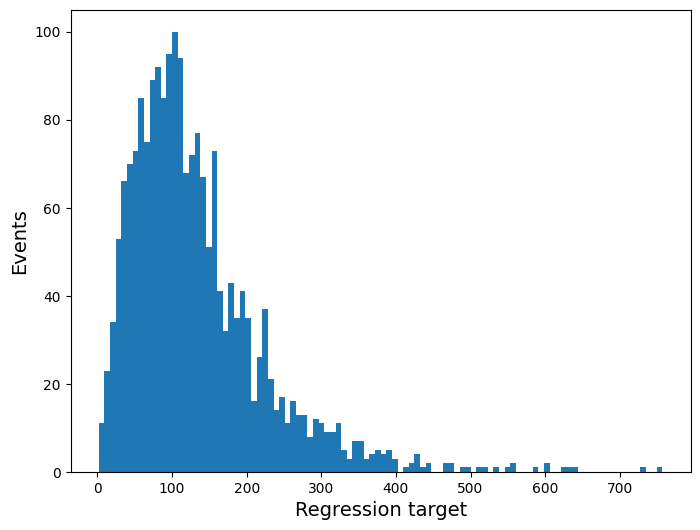

In [6]:
plt.figure()
plt.hist(y_test.values,bins=100)
plt.xlabel("Regression target")
plt.ylabel("Events")
plt.show()
plt.close()

Now, since the target is a regression, we need to tweak two things.

First, the last activation function should not be a `nn.Sigmoid()` (for binary classification) or `nn.Softmax()` (for categorical classification) anymore (which forces the output to be in the range `[0,1]`. You should now use `nn.ReLU()`, which only forces the output to be a positive number.

Second, the cross entropy loss is not appropriate anymore. You should use the `MSELoss()`, ie. mean-squared error loss, simply defined as $(y_\textrm{true}-y_\textrm{pred})^{2}$.

With these two changes, you should be able to regress the Higgs boson transverse momentum.

Plot the loss function, and then produce a scatter plot of the neural network prediction versus the true value of the Higgs transverse momentum (`y` vs `pred=model(x)`). Finally, produce a plot where you show the shape of the pT regressor separately for the signal, for bkg1 (ttW),  and for bkg2 (Drell-Yan). For this latest plot, you should normalize to 1 the three distributions, to check for shape differences (you can use `density=True` when plotting).

In [7]:
class NeuralNetwork(nn.Module):
    def __init__(self, ninputs, device=torch.device("cpu")):
        super().__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(ninputs, 512),
            nn.ReLU(),
            nn.Linear(512,128),
            nn.ReLU(),
            nn.Linear(128,64),
            nn.ReLU(),
            nn.Linear(64, 1),
            nn.ReLU()
        )
        self.linear_relu_stack.to(device)

    def forward(self, x):
        # Pass data through conv1
        x = self.linear_relu_stack(x)
        return x
# Reinstantiate the model, on the chosen device
model = NeuralNetwork(X_train.shape[1], device)

loss_fn = torch.nn.MSELoss()
#loss_fn = torch.nn.L1Loss()
#loss_fn = nn.HuberLoss()

epochs=50
learningRate = 0.01
optimizer = torch.optim.SGD(model.parameters(), lr=learningRate)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

def train_loop(dataloader, model, loss_fn, optimizer, scheduler, device):
    size = len(dataloader.dataset)
    losses=[] # Track the loss function
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.train()
    #for batch, (X, y) in enumerate(dataloader):
    for (X,y) in tqdm(dataloader):
        # Reset gradients (to avoid their accumulation)
        optimizer.zero_grad()
        # Compute prediction and loss
        pred = model(X)
        #if (all_equal3(pred.detach().numpy())):
        #    print("All equal!")
        loss = loss_fn(pred.squeeze(dim=1), y)
        losses.append(loss.detach().cpu())
        # Backpropagation
        loss.backward()
        optimizer.step()

    scheduler.step()
    return np.mean(losses)

def test_loop(dataloader, model, loss_fn, device):
    losses=[] # Track the loss function
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for X, y in dataloader:
        #for (X,y) in tqdm(dataloader):
            pred = model(X)
            loss = loss_fn(pred.squeeze(dim=1), y).item()
            losses.append(loss)
            test_loss += loss
            #correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            
    return np.mean(losses)

train_losses=[]
test_losses=[]
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loss=train_loop(train_dataloader, model, loss_fn, optimizer, scheduler, device)
    test_loss=test_loop(test_dataloader, model, loss_fn, device)
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    print("Avg train loss", train_loss, ", Avg test loss", test_loss, "Current learning rate", scheduler.get_last_lr())
print("Done!")

Epoch 1
-------------------------------


100%|██████████| 5/5 [00:00<00:00, 10.38it/s]


Avg train loss nan , Avg test loss nan Current learning rate [0.009000000000000001]
Epoch 2
-------------------------------


100%|██████████| 5/5 [00:00<00:00, 63.71it/s]


Avg train loss nan , Avg test loss nan Current learning rate [0.008100000000000001]
Epoch 3
-------------------------------


100%|██████████| 5/5 [00:00<00:00, 63.37it/s]


Avg train loss nan , Avg test loss nan Current learning rate [0.007290000000000001]
Epoch 4
-------------------------------


100%|██████████| 5/5 [00:00<00:00, 62.19it/s]


Avg train loss nan , Avg test loss nan Current learning rate [0.006561000000000002]
Epoch 5
-------------------------------


100%|██████████| 5/5 [00:00<00:00, 61.30it/s]


Avg train loss nan , Avg test loss nan Current learning rate [0.005904900000000002]
Epoch 6
-------------------------------


100%|██████████| 5/5 [00:00<00:00, 62.08it/s]


Avg train loss nan , Avg test loss nan Current learning rate [0.005314410000000002]
Epoch 7
-------------------------------


100%|██████████| 5/5 [00:00<00:00, 62.35it/s]


Avg train loss nan , Avg test loss nan Current learning rate [0.004782969000000002]
Epoch 8
-------------------------------


100%|██████████| 5/5 [00:00<00:00, 64.14it/s]


Avg train loss nan , Avg test loss nan Current learning rate [0.004304672100000002]
Epoch 9
-------------------------------


100%|██████████| 5/5 [00:00<00:00, 61.93it/s]


Avg train loss nan , Avg test loss nan Current learning rate [0.003874204890000002]
Epoch 10
-------------------------------


100%|██████████| 5/5 [00:00<00:00, 61.28it/s]


Avg train loss nan , Avg test loss nan Current learning rate [0.003486784401000002]
Epoch 11
-------------------------------


100%|██████████| 5/5 [00:00<00:00, 62.82it/s]


Avg train loss nan , Avg test loss nan Current learning rate [0.003138105960900002]
Epoch 12
-------------------------------


100%|██████████| 5/5 [00:00<00:00, 26.44it/s]


Avg train loss nan , Avg test loss nan Current learning rate [0.0028242953648100018]
Epoch 13
-------------------------------


100%|██████████| 5/5 [00:00<00:00, 59.92it/s]


Avg train loss nan , Avg test loss nan Current learning rate [0.0025418658283290017]
Epoch 14
-------------------------------


100%|██████████| 5/5 [00:00<00:00, 62.99it/s]


Avg train loss nan , Avg test loss nan Current learning rate [0.0022876792454961017]
Epoch 15
-------------------------------


100%|██████████| 5/5 [00:00<00:00, 62.19it/s]


Avg train loss nan , Avg test loss nan Current learning rate [0.0020589113209464917]
Epoch 16
-------------------------------


100%|██████████| 5/5 [00:00<00:00, 62.53it/s]


Avg train loss nan , Avg test loss nan Current learning rate [0.0018530201888518425]
Epoch 17
-------------------------------


100%|██████████| 5/5 [00:00<00:00, 63.82it/s]


Avg train loss nan , Avg test loss nan Current learning rate [0.0016677181699666583]
Epoch 18
-------------------------------


100%|██████████| 5/5 [00:00<00:00, 26.74it/s]


Avg train loss nan , Avg test loss nan Current learning rate [0.0015009463529699924]
Epoch 19
-------------------------------


100%|██████████| 5/5 [00:00<00:00, 63.54it/s]


Avg train loss nan , Avg test loss nan Current learning rate [0.0013508517176729932]
Epoch 20
-------------------------------


100%|██████████| 5/5 [00:00<00:00, 63.48it/s]


Avg train loss nan , Avg test loss nan Current learning rate [0.001215766545905694]
Epoch 21
-------------------------------


100%|██████████| 5/5 [00:00<00:00, 62.27it/s]


Avg train loss nan , Avg test loss nan Current learning rate [0.0010941898913151245]
Epoch 22
-------------------------------


100%|██████████| 5/5 [00:00<00:00, 61.25it/s]


Avg train loss nan , Avg test loss nan Current learning rate [0.0009847709021836122]
Epoch 23
-------------------------------


100%|██████████| 5/5 [00:00<00:00, 60.94it/s]


Avg train loss nan , Avg test loss nan Current learning rate [0.0008862938119652509]
Epoch 24
-------------------------------


100%|██████████| 5/5 [00:00<00:00, 26.56it/s]


Avg train loss nan , Avg test loss nan Current learning rate [0.0007976644307687258]
Epoch 25
-------------------------------


100%|██████████| 5/5 [00:00<00:00, 61.43it/s]


Avg train loss nan , Avg test loss nan Current learning rate [0.0007178979876918532]
Epoch 26
-------------------------------


100%|██████████| 5/5 [00:00<00:00, 61.19it/s]


Avg train loss nan , Avg test loss nan Current learning rate [0.0006461081889226679]
Epoch 27
-------------------------------


100%|██████████| 5/5 [00:00<00:00, 61.77it/s]


Avg train loss nan , Avg test loss nan Current learning rate [0.0005814973700304011]
Epoch 28
-------------------------------


100%|██████████| 5/5 [00:00<00:00, 62.28it/s]


Avg train loss nan , Avg test loss nan Current learning rate [0.0005233476330273611]
Epoch 29
-------------------------------


100%|██████████| 5/5 [00:00<00:00, 60.47it/s]


Avg train loss nan , Avg test loss nan Current learning rate [0.000471012869724625]
Epoch 30
-------------------------------


100%|██████████| 5/5 [00:00<00:00, 64.10it/s]


Avg train loss nan , Avg test loss nan Current learning rate [0.0004239115827521625]
Epoch 31
-------------------------------


100%|██████████| 5/5 [00:00<00:00, 26.34it/s]

Avg train loss nan , Avg test loss nan Current learning rate [0.00038152042447694626]
Epoch 32
-------------------------------



100%|██████████| 5/5 [00:00<00:00, 63.09it/s]


Avg train loss nan , Avg test loss nan Current learning rate [0.00034336838202925164]
Epoch 33
-------------------------------


100%|██████████| 5/5 [00:00<00:00, 62.36it/s]


Avg train loss nan , Avg test loss nan Current learning rate [0.0003090315438263265]
Epoch 34
-------------------------------


100%|██████████| 5/5 [00:00<00:00, 62.55it/s]


Avg train loss nan , Avg test loss nan Current learning rate [0.00027812838944369386]
Epoch 35
-------------------------------


100%|██████████| 5/5 [00:00<00:00, 61.84it/s]


Avg train loss nan , Avg test loss nan Current learning rate [0.0002503155504993245]
Epoch 36
-------------------------------


100%|██████████| 5/5 [00:00<00:00, 62.43it/s]


Avg train loss nan , Avg test loss nan Current learning rate [0.00022528399544939206]
Epoch 37
-------------------------------


100%|██████████| 5/5 [00:00<00:00, 26.30it/s]

Avg train loss nan , Avg test loss nan Current learning rate [0.00020275559590445286]
Epoch 38
-------------------------------



100%|██████████| 5/5 [00:00<00:00, 62.15it/s]


Avg train loss nan , Avg test loss nan Current learning rate [0.00018248003631400757]
Epoch 39
-------------------------------


100%|██████████| 5/5 [00:00<00:00, 62.15it/s]


Avg train loss nan , Avg test loss nan Current learning rate [0.00016423203268260683]
Epoch 40
-------------------------------


100%|██████████| 5/5 [00:00<00:00, 62.79it/s]


Avg train loss nan , Avg test loss nan Current learning rate [0.00014780882941434616]
Epoch 41
-------------------------------


100%|██████████| 5/5 [00:00<00:00, 62.23it/s]


Avg train loss nan , Avg test loss nan Current learning rate [0.00013302794647291155]
Epoch 42
-------------------------------


100%|██████████| 5/5 [00:00<00:00, 61.74it/s]


Avg train loss nan , Avg test loss nan Current learning rate [0.00011972515182562039]
Epoch 43
-------------------------------


100%|██████████| 5/5 [00:00<00:00, 51.86it/s]


Avg train loss nan , Avg test loss nan Current learning rate [0.00010775263664305835]
Epoch 44
-------------------------------


100%|██████████| 5/5 [00:00<00:00, 61.23it/s]


Avg train loss nan , Avg test loss nan Current learning rate [9.697737297875251e-05]
Epoch 45
-------------------------------


100%|██████████| 5/5 [00:00<00:00, 61.41it/s]


Avg train loss nan , Avg test loss nan Current learning rate [8.727963568087727e-05]
Epoch 46
-------------------------------


100%|██████████| 5/5 [00:00<00:00, 36.17it/s]


Avg train loss nan , Avg test loss nan Current learning rate [7.855167211278955e-05]
Epoch 47
-------------------------------


100%|██████████| 5/5 [00:00<00:00, 62.36it/s]


Avg train loss nan , Avg test loss nan Current learning rate [7.06965049015106e-05]
Epoch 48
-------------------------------


100%|██████████| 5/5 [00:00<00:00, 61.40it/s]


Avg train loss nan , Avg test loss nan Current learning rate [6.362685441135955e-05]
Epoch 49
-------------------------------


100%|██████████| 5/5 [00:00<00:00, 61.63it/s]


Avg train loss nan , Avg test loss nan Current learning rate [5.7264168970223595e-05]
Epoch 50
-------------------------------


100%|██████████| 5/5 [00:00<00:00, 26.16it/s]


Avg train loss nan , Avg test loss nan Current learning rate [5.153775207320124e-05]
Done!


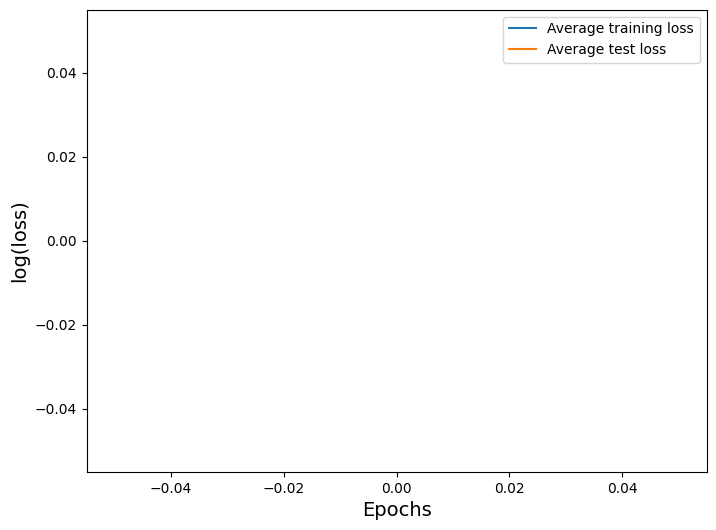

In [8]:
#remove first 5 epochs since the loss can be very high at the beginning
plt.plot(np.log(train_losses[5:]), label="Average training loss")
plt.plot(np.log(test_losses[5:]), label="Average test loss")
plt.ylabel("log(loss)")
plt.xlabel("Epochs")
plt.legend(loc="best")

## What is going on!?!??! Why is the loss always NotANumber?

This is because the network is not managing to cope with the vast range of values for the output (the pT).

Try reducing the range of values by adding, in correspondence of `# MIMIMI HERE SOMETHING THERE WILL BE`, the following transformation:


`y = signal["Hreco_HTXS_Higgs_pt"].apply(np.log)`

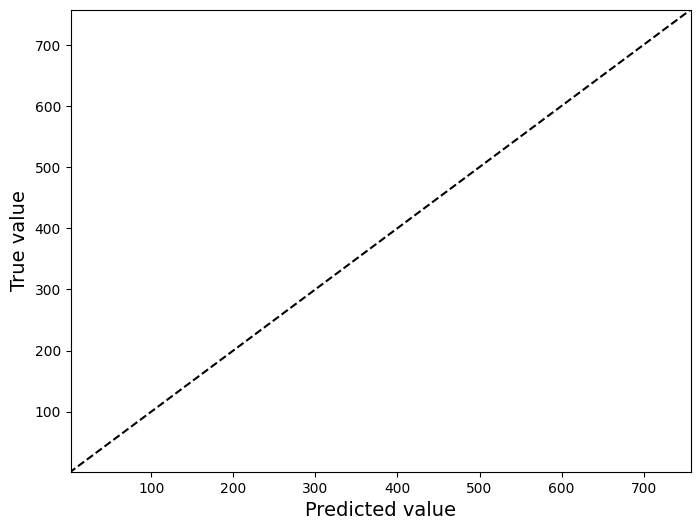

In [9]:
plt.figure()
y_pred = model(torch.tensor(X_test.values, device=device)).numpy(force=True)[:,0]
plt.scatter(y_pred, y_test.values, marker='o', s=1.)
plt.xlabel("Predicted value")
plt.ylabel("True value")
plt.ylim(min(y_test),max(y_test))
plt.xlim(min(y_test),max(y_test))
plt.plot([0,max(y_test)],[0,max(y_test)],linestyle='--',c='black')
plt.show()
plt.close()

/blue/avery/ekoenig/conda/envs/cmsdas/lib/python3.10/site-packages/matplotlib/axes/_axes.py:6973: RuntimeWarning: All-NaN slice encountered
  xmin = min(xmin, np.nanmin(xi))
/blue/avery/ekoenig/conda/envs/cmsdas/lib/python3.10/site-packages/matplotlib/axes/_axes.py:6974: RuntimeWarning: All-NaN slice encountered
  xmax = max(xmax, np.nanmax(xi))


ValueError: autodetected range of [nan, nan] is not finite

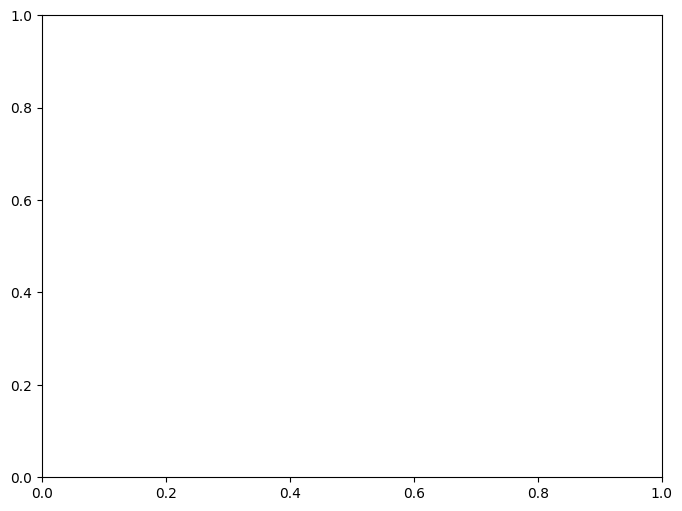

In [10]:
plt.figure()
y_pred = model(torch.tensor(X_test.values, device=device)).numpy(force=True)[:,0]
diff = y_pred-y_test.values
hist,_,_ = plt.hist(diff, bins=100)
fractions = [2.3,15.85,50,84.15,97.7]
percentiles = np.percentile(diff,fractions)
for i in range(len(percentiles)):
    plt.plot([percentiles[i],percentiles[i]],[0,max(hist)*1.1],c='black',linestyle='--')
    plt.text(percentiles[i],max(hist)*1.11,f"{fractions[i]:.0f}%")
plt.xlabel("Predicted value - True value")
plt.show()
plt.close()

## Somehow better, but still suboptimal!

The spread of the predictions is too large to be used. Nonconvex optimization is difficult, and sometimes tweaking the model and training to success is tricky.

A way of hacking this problem is to use a more sophisticated loss function that penalizes predictions with different means. You can try!

```
class penalized_mse(nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, pred, target):
        #return ((pred-target)**2).mean() + 2*((torch.log(pred)-torch.log(target))**2).mean()
        print(pred.mean(), pred.var(),target.var())
        return ((pred-target)**2).mean()*(torch.abs(pred.var()-target.var()))

loss_fn=penalized_mse()
```

Also see if modifying the network can help to improve the prediction. For example ...
* add dropout layers
* use a different activation function
* add batch normalization layers
* reduce the number of layer
* reduce the number of nodes

### The end